# 데이터 불러오기

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

Resuming download from 148897792 bytes (2314467643 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia?dataset_version_number=2 (148897792/2463365435) bytes left.


100%|██████████| 2.29G/2.29G [03:28<00:00, 11.1MB/s]

Extracting files...


Dataset path: /Users/carki/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [4]:
import torch
import os

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2

transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


In [10]:
it = iter(range(3))
next(it)
next(it)
next(it)

2

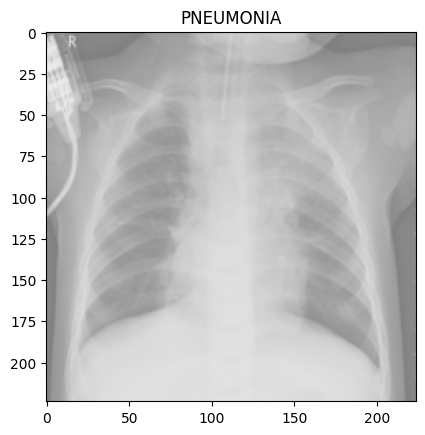

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))

# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

In [12]:
# 데이터 전처리 정의
data_transforms = {
    'train': v2.Compose([
        v2.Resize((224, 224)),                # 이미지 크기 조정
        v2.RandomCrop((200, 200)),           # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),              # 랜덤 회전 (-20도 ~ 20도)
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])           # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((224, 224)),               # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])           # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((224, 224)),               # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])           # 정규화
    ])
}

/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
from torchvision import datasets
from torch.utils.data import DataLoader

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


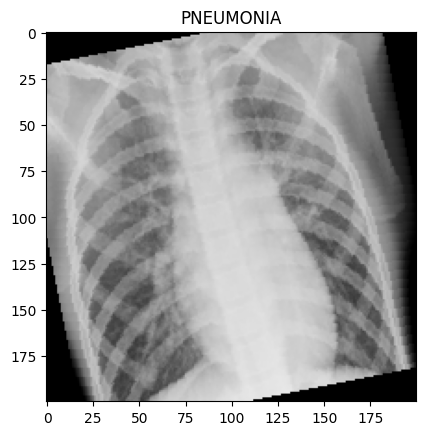

In [14]:
# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))

# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

# Custom CNN 모델 생성

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 입력 채널: 3, 출력 채널: 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                  # MaxPooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Conv2D
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))                       # Adaptive Pooling (7x7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                             # Fully Connected Layer
        self.fc2 = nn.Linear(128, num_classes)                            # Output Layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + Pooling
        x = self.avgpool(x)                   # Adaptive Pooling
        x = torch.flatten(x, 1)               # Flattening
        x = F.relu(self.fc1(x))               # Fully Connected Layer 1
        x = self.fc2(x)                       # Output Layer
        return x

# 클래스 수 설정 (NORMAL, PNEUMONIA)
num_classes = len(class_names)

In [16]:
import torch.optim as optim

model = CustomCNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 및 평가

In [17]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    step = 0
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # 데이터를 GPU/CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 이전 그래디언트 초기화
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()  # Backward Pass

            # 가중치 업데이트
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            step += 1

        # 학습 손실 및 정확도 출력
        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # 검증 단계 수행
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [18]:
def evaluate(model, dataloader, loss_fn):
    model.eval()

    losses = []  # 손실값을 저장할 리스트
    correct = 0  # 올바르게 예측한 샘플 수
    total = 0    # 전체 샘플 수

    with torch.no_grad():
        for inputs, labels in dataloader:
            # 데이터를 GPU 또는 CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델의 예측값 계산
            outputs = model(inputs)

            # 손실값 계산
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # 예측값 가져오기
            pred_labels = torch.argmax(outputs, dim=1)  # [배치 크기]
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

    # 평균 손실값과 정확도 계산
    avg_loss = sum(losses) / len(losses)
    accuracy = correct / total

    return avg_loss, accuracy

In [19]:
train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.3096, Train Acc: 0.8648, Val Loss: 0.5974, Val Acc: 0.6250
Epoch 2/10, Train Loss: 0.2105, Train Acc: 0.9164, Val Loss: 0.7706, Val Acc: 0.6250
Epoch 3/10, Train Loss: 0.1708, Train Acc: 0.9337, Val Loss: 0.7078, Val Acc: 0.7500
Epoch 4/10, Train Loss: 0.1429, Train Acc: 0.9480, Val Loss: 0.7303, Val Acc: 0.6875
Epoch 5/10, Train Loss: 0.1419, Train Acc: 0.9450, Val Loss: 0.9499, Val Acc: 0.6250
Epoch 6/10, Train Loss: 0.1334, Train Acc: 0.9480, Val Loss: 0.6222, Val Acc: 0.6875
Epoch 7/10, Train Loss: 0.1292, Train Acc: 0.9517, Val Loss: 0.7032, Val Acc: 0.6250
Epoch 8/10, Train Loss: 0.1243, Train Acc: 0.9538, Val Loss: 0.4267, Val Acc: 0.7500
Epoch 9/10, Train Loss: 0.1170, Train Acc: 0.9561, Val Loss: 1.0913, Val Acc: 0.5625
Epoch 10/10, Train Loss: 0.1119, Train Acc: 0.9569, Val Loss: 0.3881, Val Acc: 0.8125


In [ ]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn)
test_acc

0.8782051282051282

# Transfer Learning

In [ ]:
import torchvision.models as models

# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# Feature Extractor 동결 (파라미터 업데이트 불가)
for param in pretrained_model.parameters():
    param.requires_grad = False

# Classifier 교체 (기존 Fully Connected Layer를 새로운 Classifier로 교체)
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(pretrained_model.fc.weight.device)

cuda:0


In [ ]:
# 손실 함수와 Optimizer 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.6512, Train Acc: 0.6263, Val Loss: 0.8364, Val Acc: 0.4375
Epoch 2/10, Train Loss: 0.6595, Train Acc: 0.6242, Val Loss: 0.8347, Val Acc: 0.4375
Epoch 3/10, Train Loss: 0.6548, Train Acc: 0.6273, Val Loss: 0.8411, Val Acc: 0.4375
Epoch 4/10, Train Loss: 0.6553, Train Acc: 0.6279, Val Loss: 0.8434, Val Acc: 0.4375
Epoch 5/10, Train Loss: 0.6563, Train Acc: 0.6252, Val Loss: 0.8380, Val Acc: 0.4375
Epoch 6/10, Train Loss: 0.6563, Train Acc: 0.6283, Val Loss: 0.8334, Val Acc: 0.4375
Epoch 7/10, Train Loss: 0.6530, Train Acc: 0.6315, Val Loss: 0.8449, Val Acc: 0.4375
Epoch 8/10, Train Loss: 0.6522, Train Acc: 0.6302, Val Loss: 0.8323, Val Acc: 0.4375
Epoch 9/10, Train Loss: 0.6516, Train Acc: 0.6244, Val Loss: 0.8304, Val Acc: 0.4375
Epoch 10/10, Train Loss: 0.6570, Train Acc: 0.6285, Val Loss: 0.8371, Val Acc: 0.4375


(0.7750958919525146, 0.48717948717948717)

# Transfer Learning (Partial Fine-Tuning)

In [ ]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# Feature Extractor의 초기 층 동결
for name, param in pretrained_model.named_parameters():
    if "layer4" in name or "fc" in name:  # ResNet의 마지막 블록(layer4)와 Fully Connected Layer만 학습 가능
        param.requires_grad = True
    else:
        param.requires_grad = False

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성

print("Trainable parameters:")
for name, param in pretrained_model.named_parameters():
    if param.requires_grad:
        print(name)

pretrained_model = pretrained_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [ ]:
# 손실 함수와 Optimizer 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.6487, Train Acc: 0.7427, Val Loss: 0.9259, Val Acc: 0.5000
Epoch 2/10, Train Loss: 0.6479, Train Acc: 0.7427, Val Loss: 0.9330, Val Acc: 0.5000
Epoch 3/10, Train Loss: 0.6461, Train Acc: 0.7427, Val Loss: 0.9284, Val Acc: 0.5000
Epoch 4/10, Train Loss: 0.6466, Train Acc: 0.7425, Val Loss: 0.9358, Val Acc: 0.5000
Epoch 5/10, Train Loss: 0.6461, Train Acc: 0.7429, Val Loss: 0.9218, Val Acc: 0.5000
Epoch 6/10, Train Loss: 0.6490, Train Acc: 0.7425, Val Loss: 0.9367, Val Acc: 0.5000
Epoch 7/10, Train Loss: 0.6508, Train Acc: 0.7427, Val Loss: 0.9320, Val Acc: 0.5000
Epoch 8/10, Train Loss: 0.6418, Train Acc: 0.7425, Val Loss: 0.9272, Val Acc: 0.5000
Epoch 9/10, Train Loss: 0.6432, Train Acc: 0.7427, Val Loss: 0.9368, Val Acc: 0.5000
Epoch 10/10, Train Loss: 0.6426, Train Acc: 0.7425, Val Loss: 0.9251, Val Acc: 0.5000


(0.6997766479849815, 0.6282051282051282)

# Transfer Learning (Full Fine-Tuning)

In [ ]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

In [ ]:
# 손실 함수와 Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.00001)  # Full Fine-Tuning에서는 더 낮은 학습률

In [ ]:
# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.2731, Train Acc: 0.8999, Val Loss: 0.4154, Val Acc: 0.8125
Epoch 2/10, Train Loss: 0.1156, Train Acc: 0.9609, Val Loss: 0.3933, Val Acc: 0.7500
Epoch 3/10, Train Loss: 0.0922, Train Acc: 0.9689, Val Loss: 0.4211, Val Acc: 0.6875
Epoch 4/10, Train Loss: 0.0819, Train Acc: 0.9707, Val Loss: 0.3053, Val Acc: 0.7500
Epoch 5/10, Train Loss: 0.0654, Train Acc: 0.9785, Val Loss: 0.2799, Val Acc: 0.8125
Epoch 6/10, Train Loss: 0.0556, Train Acc: 0.9810, Val Loss: 0.3343, Val Acc: 0.8125
Epoch 7/10, Train Loss: 0.0575, Train Acc: 0.9795, Val Loss: 0.3059, Val Acc: 0.8125
Epoch 8/10, Train Loss: 0.0457, Train Acc: 0.9833, Val Loss: 0.4129, Val Acc: 0.8125
Epoch 9/10, Train Loss: 0.0457, Train Acc: 0.9845, Val Loss: 0.3989, Val Acc: 0.8125
Epoch 10/10, Train Loss: 0.0445, Train Acc: 0.9847, Val Loss: 0.1562, Val Acc: 0.8750


(0.37792747931089254, 0.8846153846153846)